In [1]:
!hostname
!pip install pandas==2.2.3 \
xgboost==2.1.2 \
catboost==1.2.7 \
lightgbm==4.5.0 \
loky==3.4.1 \
scikit-learn==1.5.2 \
joblib==1.4.2 \
seaborn==0.13.2 \
kaggle==1.6.17 \
tqdm==4.66.6 \
colorama==0.4.6 \
biosppy==0.8.0 \
neurokit2==0.2.10 \
imbalanced-learn==0.12.4 \
pywavelets==1.7.0 \
entropy==0.1.5 \
torch==2.5.1 \
torchvision==0.20.1

150-136-220-222
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import sys

base_path = './tibo1/project/Lab3'
# Set the working directory to the project root
#os.chdir('./tibo1/project/Lab3')

# Convert to absolute path and add to sys.path
sys.path.append(os.path.abspath(base_path))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
from utils import get_device
from torch import Tensor
from dataset import MyDataset
import multiprocessing
from model import UNet

import torchvision.transforms.v2 as T

### 1. Training
#### 1a. Load the Data

In [4]:
# Load data
preprocessed_expert_data_only_annotated = np.load('./out/preprocessed6bis/expert_train_annotated_frames.npy', allow_pickle=True)
preprocessed_amateur_data_only_annotated = np.load('./out/preprocessed6bis/amateur_train_annotated_frames.npy',allow_pickle=True)
preprocessed_test_data = np.load('./out/preprocessed6bis/test_processed_with_boxes.npy', allow_pickle=True)

In [5]:
# Constants
n_amateur = 25  # Lower duplication factor for amateur data
BATCH_SIZE = 16

# Balance the dataset by concatenation
concat_amateur_only_annot = np.concatenate([preprocessed_amateur_data_only_annotated] * n_amateur)

### Stack with boxes for training data loaders

In [6]:
filtered_amateur_data = [video for video in concat_amateur_only_annot if len(video['video']) > 0]

x_amateur, y_amateur = [], []

for video in filtered_amateur_data:
    for i, frame in enumerate(video['video']):
        X = np.stack([
            frame,  # Single video frame
            video["box"]  # Box (mask) for the current frame
        ], axis=0)  # Stack channel-wise
        #X = np.squeeze(X)
        x_amateur.append(X)  # Append each frame
        y_amateur.append(video['label'][i] / 255)

### Split in Training and Validation Sets

In [7]:
# Split into train and validation sets
from sklearn.model_selection import train_test_split

amateur_X_train, amateur_X_val, amateur_y_train, amateur_y_val = train_test_split(x_amateur, y_amateur, test_size=0.2)
amateur_X_train, amateur_X_val, amateur_y_train, amateur_y_val = (np.array(amateur_X_train),
                                                                  np.array(amateur_X_val),
                                                                  np.array(amateur_y_train),
                                                                  np.array(amateur_y_val))

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
device = get_device().type
use_amp = device == 'cuda'  # Use AMP only if on CUDA
BATCH_SIZE = 16
num_workers = multiprocessing.cpu_count()

#### 1b. Create the Dataloaders with Transformations and Data Augmentation

In [9]:
#from augment import RandomEraseFromLabel

#trans = T.Compose(
#    [
#        #RandomEraseFromLabel(radius=(0.02, 0.04), channels=(0, 1), p=0.9),
#        T.RandomAffine(
#            degrees=(-15, 15),
#            translate=(0.1, 0.1),
#            scale=(0.9, 1.1),
#            shear=(-15, 15),
#            interpolation=T.InterpolationMode.BILINEAR,
#        ),
#        T.RandomPerspective(),
#    ]
#)

# Transformations for training
amateur_transforms = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
])

# Create datasets and dataloaders for amateur training
train_amateur_dataset = MyDataset(amateur_X_train, amateur_y_train, transform=amateur_transforms, perc_transform=50)
val_amateur_dataset = MyDataset(amateur_X_val, amateur_y_val)

train_amateur_loader = DataLoader(train_amateur_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
val_amateur_loader = DataLoader(val_amateur_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"Amateur Data: {len(amateur_X_train)} training frames, {len(amateur_X_val)} validation frames on {num_workers} workers.")

Amateur Data: 2760 training frames, 690 validation frames on 30 workers.


#### 1c. Define the Model (U-Net)

| **Aspect**             | **Concatenation**                         | **Addition**                              |
|-------------------------|-------------------------------------------|-------------------------------------------|
| **Feature Combination** | Combines all features (doubles channels). | Merges features (no change in channels).  |
| **Parameter Efficiency**| More parameters due to increased channels.| Fewer parameters; efficient.              |
| **Memory Usage**        | Higher memory usage.                      | Lower memory usage.                       |
| **Use Case**            | Tasks requiring high precision (e.g., segmentation).| Tasks prioritizing efficiency or residual learning. |


**Dimension Example**

For an input of $1 \times 1 \times 256 \times 256$ (batch size, channels, height, width):

| Step | Output Dimensions (Your UNet and Modular UNet) |
| --- | --- |
| Conv1 | 64×256×25664 \times 256 \times 25664×256×256 |
| Pool1 | 64×128×12864 \times 128 \times 12864×128×128 |
| Conv2 | 128×128×128128 \times 128 \times 128128×128×128 |
| Pool2 | 128×64×64128 \times 64 \times 64128×64×64 |
| Conv3 | 256×64×64256 \times 64 \times 64256×64×64 |
| Pool3 | 256×32×32256 \times 32 \times 32256×32×32 |
| Conv4 | 512×32×32512 \times 32 \times 32512×32×32 |
| Pool4 | 512×16×16512 \times 16 \times 16512×16×16 |
| Conv5 | 1024×16×161024 \times 16 \times 161024×16×16 |
| Up6 + Skip4 | 1024×32×321024 \times 32 \times 321024×32×32 |
| Conv6 | 512×32×32512 \times 32 \times 32512×32×32 |
| Up7 + Skip3 | 512×64×64512 \times 64 \times 64512×64×64 |
| Conv7 | 256×64×64256 \times 64 \times 64256×64×64 |
| Up8 + Skip2 | 256×128×128256 \times 128 \times 128256×128×128 |
| Conv8 | 128×128×128128 \times 128 \times 128128×128×128 |
| Up9 + Skip1 | 128×256×256128 \times 256 \times 256128×256×256 |
| Conv9 | 64×256×25664 \times 256 \times 25664×256×256 |
| Output Conv | n_classes×256×256n\_classes \times 256 \times 256n_classes×256×256 |


#### 1d. Define the Loss Function and Optimizer

#### 1g. Metrics for Evaluation

**Dice Coefficient**
- **Intuition** : Measures the overlap between predicted and ground truth masks. Values range from 0 (no overlap) to 1 (perfect overlap). Useful for imbalanced datasets.

- **Formula** :
$$
 \text{Dice Coefficient} = \frac{2 \cdot |A \cap B|}{|A| + |B|}
$$


---

**Dice Loss**
- **Intuition** : Penalizes poor segmentation overlap. Loss decreases as overlap improves.

- **Formula** :
$$
 \text{Dice Loss} = 1 - \text{Dice Coefficient}
$$


---

**IoU Coefficient**
- **Intuition** : Ratio of overlap to total area. Complements Dice for evaluating segmentation.

- **Formula** :
$$
 \text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{|A \cap B|}{|A| + |B| - |A \cap B|}
$$

In [8]:
# Define the Dice coefficient and Dice loss
def dice_coeff(input: Tensor, target: Tensor, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    iou = iou_coeff(input, target, smooth=epsilon)
    return (2 * iou) / (iou + 1)


def dice_loss(input: Tensor, target: Tensor):
    # Dice loss (objective to minimize) between 0 and 1
    return 1 - dice_coeff(input, target)


def iou_coeff(y_true: Tensor, y_pred: Tensor, smooth=1e-6):
    y_true = y_true.float().view(-1)
    y_pred = y_pred.float().view(-1)

    # intersection is equivalent to True Positive count
    # union is the mutually inclusive area of all labels & predictions
    intersection = (y_true * y_pred).sum()
    total = (y_true + y_pred).sum()
    union = total - intersection

    return (intersection + smooth) / (union + smooth)


# Define loss functions and metrics
def power_jaccard_loss(y_true, y_pred, p=2, smooth=1e-6):
    y_true = y_true.float().view(-1)
    y_pred = y_pred.float().view(-1)
    intersection = (y_true * y_pred).sum()
    total = (torch.pow(y_true, p) + torch.pow(y_pred, p)).sum()
    union = total - intersection
    IoU = (intersection + smooth) / (union + smooth)
    return 1 - IoU

#### 1e. Training Loop

In [11]:
import os
import re
from tqdm import tqdm
import torch
import torch.optim as optim
from torch import Tensor
from model import UNet
from utils import get_device


# Training function
def train_model(train_loader, val_loader, checkpoint_dir, EPOCHS=40, LEARNING_RATE=3e-4):
    device = get_device()
    print("Running on device:", device)

    # Ensure checkpoint directory exists
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # Search for the latest checkpoint
    last_checkpoint = None
    last_epoch = 0
    for file_name in os.listdir(checkpoint_dir):
        match = re.match(r'checkpoint_epoch(\d+)\.pth', file_name)
        if match:
            epoch_num = int(match.group(1))
            if epoch_num > last_epoch:
                last_epoch = epoch_num
                last_checkpoint = os.path.join(checkpoint_dir, file_name)

    # Initialize model, optimizer, scheduler
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    model = UNet(n_classes=1, n_channels=2, bilinear=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.999)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)
    criterion = power_jaccard_loss

    # Resume from checkpoint if available
    if last_checkpoint:
        print(f"Resuming training from checkpoint: {last_checkpoint}")
        model.load_state_dict(torch.load(last_checkpoint, weights_only=True))
        optimizer.load_state_dict(
            torch.load(os.path.join(checkpoint_dir, f'optimizer_epoch{last_epoch}.pth'), weights_only=True))
        print(f"Resumed from epoch {last_epoch}")
    else:
        print("No checkpoint found. Starting training from scratch.")

    # Initialize metrics
    best_val_loss = float('inf')
    train_losses, val_losses, val_dices, val_ious = [], [], [], []

    # Training loop
    for epoch in range(last_epoch + 1, EPOCHS + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch}/{EPOCHS}', unit='batch') as pbar:
            for images, masks in train_loader:
                images = images.to(device, dtype=torch.float32)
                masks = masks.to(device, dtype=torch.float32)

                assert masks.max().item() <= 1

                optimizer.zero_grad()
                outputs = model(images)

                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                pbar.set_postfix({'loss': loss.item()})
                pbar.update()

        # Validation loop
        model.eval()
        val_loss, dice_score, iou_score = 0, 0, 0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device, dtype=torch.float32)
                masks = masks.to(device, dtype=torch.float32)

                outputs = model(images)

                outputs = ((outputs > 0.5) * 1).float()

                loss = criterion(outputs, masks)

                val_loss += loss.item()

                dice_score += dice_coeff(outputs, masks).item()
                iou_score += iou_coeff(outputs, masks).item()

        # Averaging metrics
        val_loss /= len(val_loader)
        dice_score /= len(val_loader)
        iou_score /= len(val_loader)
        scheduler.step(dice_score)

        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss)
        val_dices.append(dice_score)
        val_ious.append(iou_score)

        print(f"Epoch {epoch}: Train Loss {train_losses[-1]:.4f}, Val Loss {val_losses[-1]:.4f}, "
              f"Dice {dice_score:.4f}, IoU {iou_score:.4f}")

        # Save model and optimizer state
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'checkpoint_epoch{epoch}.pth'))
        torch.save(optimizer.state_dict(), os.path.join(checkpoint_dir, f'optimizer_epoch{epoch}.pth'))

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(checkpoint_dir, f'best_model_epoch_{epoch}.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with validation loss {best_val_loss:.4f} at epoch {epoch}")

    return train_losses, val_losses, val_dices, val_ious

In [12]:
# Example usage
train_losses, val_losses, val_dices, val_ious = train_model(
    train_loader=train_amateur_loader,
    val_loader=val_amateur_loader,
    checkpoint_dir="./out/checkpoints6bis_new_new",
    EPOCHS=40,
    LEARNING_RATE=3e-4
)

Running on device: cuda
No checkpoint found. Starting training from scratch.


Epoch 1/40: 100%|██████████| 173/173 [00:21<00:00,  7.93batch/s, loss=0.711]


Epoch 1: Train Loss 0.6737, Val Loss 0.9132, Dice 0.1588, IoU 0.0863
Best model saved with validation loss 0.9132 at epoch 1


Epoch 2/40: 100%|██████████| 173/173 [00:20<00:00,  8.51batch/s, loss=0.413]


Epoch 2: Train Loss 0.6513, Val Loss 0.8322, Dice 0.2844, IoU 0.1658
Best model saved with validation loss 0.8322 at epoch 2


Epoch 3/40: 100%|██████████| 173/173 [00:21<00:00,  8.08batch/s, loss=0.62] 


Epoch 3: Train Loss 0.6256, Val Loss 0.6717, Dice 0.4855, IoU 0.3206
Best model saved with validation loss 0.6717 at epoch 3


Epoch 4/40: 100%|██████████| 173/173 [00:22<00:00,  7.85batch/s, loss=0.681]


Epoch 4: Train Loss 0.6223, Val Loss 0.5416, Dice 0.6140, IoU 0.4431
Best model saved with validation loss 0.5416 at epoch 4


Epoch 5/40: 100%|██████████| 173/173 [00:21<00:00,  8.22batch/s, loss=0.593]


Epoch 5: Train Loss 0.6044, Val Loss 0.5387, Dice 0.6165, IoU 0.4458
Best model saved with validation loss 0.5387 at epoch 5


Epoch 6/40: 100%|██████████| 173/173 [00:21<00:00,  8.23batch/s, loss=0.685]


Epoch 6: Train Loss 0.6162, Val Loss 0.4407, Dice 0.6974, IoU 0.5357
Best model saved with validation loss 0.4407 at epoch 6


Epoch 7/40: 100%|██████████| 173/173 [00:21<00:00,  8.23batch/s, loss=0.664]


Epoch 7: Train Loss 0.6120, Val Loss 0.3030, Dice 0.7932, IoU 0.6575
Best model saved with validation loss 0.3030 at epoch 7


Epoch 8/40: 100%|██████████| 173/173 [00:20<00:00,  8.30batch/s, loss=0.541]


Epoch 8: Train Loss 0.6149, Val Loss 0.4317, Dice 0.7044, IoU 0.5439


Epoch 9/40: 100%|██████████| 173/173 [00:20<00:00,  8.41batch/s, loss=0.633]


Epoch 9: Train Loss 0.6138, Val Loss 0.4801, Dice 0.6669, IoU 0.5004


Epoch 10/40: 100%|██████████| 173/173 [00:20<00:00,  8.36batch/s, loss=0.638]


Epoch 10: Train Loss 0.6681, Val Loss 0.7970, Dice 0.3332, IoU 0.2000


Epoch 11/40: 100%|██████████| 173/173 [00:20<00:00,  8.43batch/s, loss=0.565]


Epoch 11: Train Loss 0.6251, Val Loss 0.6601, Dice 0.4791, IoU 0.3172


Epoch 12/40: 100%|██████████| 173/173 [00:20<00:00,  8.33batch/s, loss=0.713]


Epoch 12: Train Loss 0.6358, Val Loss 0.4065, Dice 0.7232, IoU 0.5667


Epoch 13/40: 100%|██████████| 173/173 [00:20<00:00,  8.28batch/s, loss=0.578]


Epoch 13: Train Loss 0.6211, Val Loss 0.5122, Dice 0.6390, IoU 0.4701


Epoch 14/40: 100%|██████████| 173/173 [00:20<00:00,  8.25batch/s, loss=0.564]


Epoch 14: Train Loss 0.6059, Val Loss 0.2905, Dice 0.8027, IoU 0.6706
Best model saved with validation loss 0.2905 at epoch 14


Epoch 15/40: 100%|██████████| 173/173 [00:20<00:00,  8.41batch/s, loss=0.701]


Epoch 15: Train Loss 0.5989, Val Loss 0.2861, Dice 0.8050, IoU 0.6739
Best model saved with validation loss 0.2861 at epoch 15


Epoch 16/40: 100%|██████████| 173/173 [00:20<00:00,  8.39batch/s, loss=0.517]


Epoch 16: Train Loss 0.6015, Val Loss 0.3752, Dice 0.7470, IoU 0.5964


Epoch 17/40: 100%|██████████| 173/173 [00:20<00:00,  8.30batch/s, loss=0.477]


Epoch 17: Train Loss 0.5882, Val Loss 0.2853, Dice 0.8042, IoU 0.6728
Best model saved with validation loss 0.2853 at epoch 17


Epoch 18/40: 100%|██████████| 173/173 [00:21<00:00,  8.08batch/s, loss=0.739]


Epoch 18: Train Loss 0.6070, Val Loss 0.3672, Dice 0.7435, IoU 0.5925


Epoch 19/40: 100%|██████████| 173/173 [00:20<00:00,  8.52batch/s, loss=0.458]


Epoch 19: Train Loss 0.6024, Val Loss 0.3162, Dice 0.7837, IoU 0.6447


Epoch 20/40: 100%|██████████| 173/173 [00:20<00:00,  8.43batch/s, loss=0.772]


Epoch 20: Train Loss 0.6548, Val Loss 0.4894, Dice 0.6538, IoU 0.4863


Epoch 21/40: 100%|██████████| 173/173 [00:20<00:00,  8.27batch/s, loss=0.617]


Epoch 21: Train Loss 0.6390, Val Loss 0.3798, Dice 0.7379, IoU 0.5855


Epoch 22/40: 100%|██████████| 173/173 [00:21<00:00,  8.20batch/s, loss=0.699]


Epoch 22: Train Loss 0.6378, Val Loss 0.3448, Dice 0.7652, IoU 0.6201


Epoch 23/40: 100%|██████████| 173/173 [00:21<00:00,  8.16batch/s, loss=0.636]


Epoch 23: Train Loss 0.6224, Val Loss 0.3347, Dice 0.7719, IoU 0.6291


Epoch 24/40: 100%|██████████| 173/173 [00:21<00:00,  8.20batch/s, loss=0.681]


Epoch 24: Train Loss 0.6264, Val Loss 0.3460, Dice 0.7633, IoU 0.6179


Epoch 25/40: 100%|██████████| 173/173 [00:20<00:00,  8.33batch/s, loss=0.53] 


Epoch 25: Train Loss 0.6113, Val Loss 0.3457, Dice 0.7637, IoU 0.6184


Epoch 26/40: 100%|██████████| 173/173 [00:20<00:00,  8.36batch/s, loss=0.333]


Epoch 26: Train Loss 0.6066, Val Loss 0.3225, Dice 0.7813, IoU 0.6414


Epoch 27/40: 100%|██████████| 173/173 [00:20<00:00,  8.32batch/s, loss=0.633]


Epoch 27: Train Loss 0.6076, Val Loss 0.2945, Dice 0.7994, IoU 0.6661


Epoch 28/40: 100%|██████████| 173/173 [00:21<00:00,  8.14batch/s, loss=0.605]


Epoch 28: Train Loss 0.6023, Val Loss 0.2967, Dice 0.7983, IoU 0.6645


Epoch 29/40: 100%|██████████| 173/173 [00:20<00:00,  8.39batch/s, loss=0.46] 


Epoch 29: Train Loss 0.5993, Val Loss 0.2949, Dice 0.7995, IoU 0.6663


Epoch 30/40: 100%|██████████| 173/173 [00:20<00:00,  8.24batch/s, loss=0.628]


Epoch 30: Train Loss 0.5987, Val Loss 0.2929, Dice 0.8010, IoU 0.6683


Epoch 31/40: 100%|██████████| 173/173 [00:21<00:00,  8.20batch/s, loss=0.746]


Epoch 31: Train Loss 0.6022, Val Loss 0.2940, Dice 0.8005, IoU 0.6676


Epoch 32/40: 100%|██████████| 173/173 [00:20<00:00,  8.33batch/s, loss=0.644]


Epoch 32: Train Loss 0.6016, Val Loss 0.2986, Dice 0.7978, IoU 0.6639


Epoch 33/40: 100%|██████████| 173/173 [00:21<00:00,  8.21batch/s, loss=0.415]


Epoch 33: Train Loss 0.5941, Val Loss 0.2936, Dice 0.8010, IoU 0.6684


Epoch 34/40: 100%|██████████| 173/173 [00:20<00:00,  8.28batch/s, loss=0.519]


Epoch 34: Train Loss 0.6000, Val Loss 0.2913, Dice 0.8024, IoU 0.6703


Epoch 35/40: 100%|██████████| 173/173 [00:21<00:00,  8.15batch/s, loss=0.421]


Epoch 35: Train Loss 0.5877, Val Loss 0.2919, Dice 0.8021, IoU 0.6699


Epoch 36/40: 100%|██████████| 173/173 [00:21<00:00,  8.01batch/s, loss=0.566]


Epoch 36: Train Loss 0.6007, Val Loss 0.3045, Dice 0.7943, IoU 0.6591


Epoch 37/40: 100%|██████████| 173/173 [00:21<00:00,  8.19batch/s, loss=0.62] 


Epoch 37: Train Loss 0.5982, Val Loss 0.2990, Dice 0.7978, IoU 0.6638


Epoch 38/40: 100%|██████████| 173/173 [00:21<00:00,  8.22batch/s, loss=0.7]  


Epoch 38: Train Loss 0.5922, Val Loss 0.2926, Dice 0.8017, IoU 0.6693


Epoch 39/40: 100%|██████████| 173/173 [00:21<00:00,  8.06batch/s, loss=0.685]


Epoch 39: Train Loss 0.6049, Val Loss 0.2952, Dice 0.8001, IoU 0.6671


Epoch 40/40: 100%|██████████| 173/173 [00:20<00:00,  8.43batch/s, loss=0.602]


Epoch 40: Train Loss 0.5991, Val Loss 0.2906, Dice 0.8029, IoU 0.6709


#### 1f. Save and Visualize Training Metrics

In [41]:
import os
import matplotlib.pyplot as plt


def save_metrics(train_losses, val_losses, val_dices, val_ious, dir_figures, name='metrics.png'):
    plt.figure(figsize=(20, 5))  # Adjusted size to fit 5 plots

    # Plot the training and validation losses (together)
    plt.subplot(1, 5, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.legend()

    # Plot the training loss separately
    plt.subplot(1, 5, 2)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Plot the validation loss separately
    plt.subplot(1, 5, 3)
    plt.plot(val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()

    # Plot the validation Dice Coefficient
    plt.subplot(1, 5, 4)
    plt.plot(val_dices, label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.title('Validation Dice Coefficient')
    plt.legend()

    # Plot the validation IoU
    plt.subplot(1, 5, 5)
    plt.plot(val_ious, label='Val IoU', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('Validation IoU')
    plt.legend()

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(os.path.join(dir_figures, name))
    plt.show()

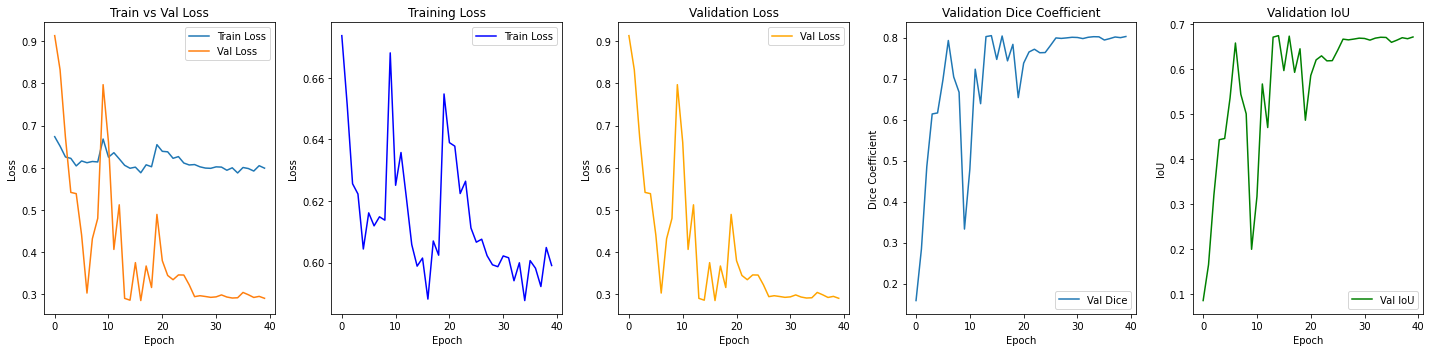

In [14]:
# Save metrics
dir_figures = './figures6bis_new_new'
os.makedirs(dir_figures, exist_ok=True)
save_metrics(train_losses, val_losses, val_dices, val_ious, dir_figures, name='metrics6bis_new_new1.png')

### 2. Fine-Tuning with EXPERT Data

In [15]:
# Split into train and validation sets
from sklearn.model_selection import train_test_split

n_expert = 50  # Higher duplication factor for expert data
concat_expert_only_annot = np.concatenate([preprocessed_expert_data_only_annotated] * n_expert)
filtered_expert_data = [video for video in concat_expert_only_annot if len(video['video']) > 0]

x_expert, y_expert = [], []
for video in filtered_expert_data:
    for i, frame in enumerate(video['video']):
        X = np.stack([
            frame,  # Single video frame
            video["box"]  # Box (mask) for the current frame
        ], axis=0)  # Stack channel-wise
        #X = np.squeeze(X)
        x_expert.append(X)  # Append each frame
        y_expert.append(video['label'][i] / 255)

In [29]:
# Create datasets and dataloaders for fine-tuning
expert_transforms = T.Compose([
    T.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
])

In [30]:
# Split expert data into train and validation sets
expert_X_train, expert_X_val, expert_y_train, expert_y_val = train_test_split(x_expert, y_expert, test_size=0.2, random_state=42)
expert_X_train, expert_X_val, expert_y_train, expert_y_val = (np.array(expert_X_train), np.array(expert_X_val), np.array(expert_y_train), np.array(expert_y_val))

# Create datasets and dataloaders for fine-tuning
train_expert_dataset = MyDataset(expert_X_train, expert_y_train, transform=expert_transforms, perc_transform=50)
val_expert_dataset = MyDataset(expert_X_val, expert_y_val)  # No transform for validation

train_expert_loader = DataLoader(train_expert_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
val_expert_loader = DataLoader(val_expert_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"Expert Data: {len(expert_X_train)} training frames, {len(expert_X_val)} validation frames on {num_workers} workers.")

Expert Data: 2280 training frames, 570 validation frames on 30 workers.


In [39]:
import os
import re
from tqdm import tqdm
import torch
import torch.optim as optim
from torch import Tensor
from model import UNet
from utils import get_device

# Training function
def train_model(train_loader, val_loader, checkpoint_dir, amateur_model_dir, EPOCHS=40, LEARNING_RATE=3e-4):
    device = get_device()
    print("Running on device:", device)

    # Ensure checkpoint directory exists
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # Search for the latest fine-tune checkpoint
    last_checkpoint = None
    last_epoch = 0
    for file_name in os.listdir(checkpoint_dir):
        match = re.match(r'checkpoint_fine_tune_epoch(\d+)\.pth', file_name)
        if match:
            epoch_num = int(match.group(1))
            if epoch_num > last_epoch:
                last_epoch = epoch_num
                last_checkpoint = os.path.join(checkpoint_dir, file_name)

    # Initialize model
    import gc
    gc.collect()
    torch.cuda.empty_cache()

    model = UNet(n_classes=1, n_channels=2, bilinear=False).to(device)

    
    optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.999)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    criterion = power_jaccard_loss

    if last_checkpoint:
        # Load fine-tuning checkpoint
        print(f"Resuming training from fine-tune checkpoint: {last_checkpoint}")
        model.load_state_dict(torch.load(last_checkpoint, weights_only=True))
        optimizer.load_state_dict(torch.load(os.path.join(checkpoint_dir, f'optimizer_fine_tune_epoch{last_epoch}.pth'), weights_only=True))
        print(f"Resumed from fine-tune epoch {last_epoch}")
    else:
        # Search for the best expert model with the highest epoch number
        best_amateur_model = None
        highest_epoch = -1  # Track the highest epoch number

        for file_name in os.listdir(amateur_model_dir):
            match = re.match(r'best_model_epoch_(\d+)\.pth', file_name)
            if match:
                epoch_num = int(match.group(1))
                if epoch_num > highest_epoch:
                    highest_epoch = epoch_num
                    best_amateur_model = os.path.join(amateur_model_dir, file_name)

        if best_amateur_model:
            print(f"Loading pretrained amateur model: {best_amateur_model}")
            model.load_state_dict(torch.load(best_amateur_model, weights_only=True))
            #optimizer.load_state_dict(torch.load(os.path.join(amateur_model_dir, f'optimizer_epoch{highest_epoch}.pth'), weights_only=True))
            optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.999)
            print(f"Loaded best expert model from epoch {highest_epoch} and a new optimizer.")
        else:
            print("No expert model found. Aborting training.")
            return


    # Initialize metrics
    best_val_loss = float('inf')
    train_losses, val_losses, val_dices, val_ious = [], [], [], []

    # Training loop
    for epoch in range(last_epoch + 1, EPOCHS + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch}/{EPOCHS}', unit='batch') as pbar:
            for images, masks in train_loader:
                images = images.to(device, dtype=torch.float32)
                masks = masks.to(device, dtype=torch.float32)

                optimizer.zero_grad()
                outputs = model(images)

                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                pbar.set_postfix({'loss': loss.item()})
                pbar.update()

        # Validation loop
        model.eval()
        val_loss, dice_score, iou_score = 0, 0, 0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device, dtype=torch.float32)
                masks = masks.to(device, dtype=torch.float32)

                outputs = model(images)

                outputs = ((outputs > 0.5) * 1).float()

                loss = criterion(outputs, masks)
                val_loss += loss.item()
                dice_score += dice_coeff(outputs, masks).item()
                iou_score += iou_coeff(outputs, masks).item()

        # Averaging metrics
        val_loss /= len(val_loader)
        dice_score /= len(val_loader)
        iou_score /= len(val_loader)
        scheduler.step(dice_score)
        current_lr = scheduler.optimizer.param_groups[0]['lr']
        print(f"Current learning rate: {current_lr}")

        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss)
        val_dices.append(dice_score)
        val_ious.append(iou_score)

        print(f"Epoch {epoch}: Train Loss {train_losses[-1]:.4f}, Val Loss {val_losses[-1]:.4f}, "
              f"Dice {dice_score:.4f}, IoU {iou_score:.4f}")

        # Save model and optimizer state
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'checkpoint_fine_tune_epoch{epoch}.pth'))
        torch.save(optimizer.state_dict(), os.path.join(checkpoint_dir, f'optimizer_fine_tune_epoch{epoch}.pth'))

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(checkpoint_dir, f'best_model_fine_tune_epoch_{epoch}.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with validation loss {best_val_loss:.4f} at epoch {epoch}")

    return train_losses, val_losses, val_dices, val_ious

In [45]:
# Example usage
train_losses, val_losses, val_dices, val_ious = train_model(
    train_loader=train_expert_loader,
    val_loader=val_expert_loader,
    checkpoint_dir="./out/checkpoints6bis_new_new",
    amateur_model_dir="./out/checkpoints6bis_new_new",
    EPOCHS=120,
    LEARNING_RATE=1e-5
)

Running on device: cuda
Resuming training from fine-tune checkpoint: ./out/checkpoints6bis_new_new/checkpoint_fine_tune_epoch80.pth
Resumed from fine-tune epoch 80


Epoch 81/120: 100%|██████████| 143/143 [00:19<00:00,  7.38batch/s, loss=0.783]


Current learning rate: 1.953125e-08
Epoch 81: Train Loss 0.6373, Val Loss 0.3834, Dice 0.7551, IoU 0.6068
Best model saved with validation loss 0.3834 at epoch 81


Epoch 82/120: 100%|██████████| 143/143 [00:18<00:00,  7.57batch/s, loss=0.618]


Current learning rate: 1.953125e-08
Epoch 82: Train Loss 0.6320, Val Loss 0.3758, Dice 0.7607, IoU 0.6140
Best model saved with validation loss 0.3758 at epoch 82


Epoch 83/120: 100%|██████████| 143/143 [00:18<00:00,  7.56batch/s, loss=0.668]


Current learning rate: 1.953125e-08
Epoch 83: Train Loss 0.6307, Val Loss 0.3755, Dice 0.7610, IoU 0.6144
Best model saved with validation loss 0.3755 at epoch 83


Epoch 84/120: 100%|██████████| 143/143 [00:18<00:00,  7.68batch/s, loss=0.57] 


Current learning rate: 1.953125e-08
Epoch 84: Train Loss 0.6365, Val Loss 0.3722, Dice 0.7633, IoU 0.6174
Best model saved with validation loss 0.3722 at epoch 84


Epoch 85/120: 100%|██████████| 143/143 [00:19<00:00,  7.51batch/s, loss=0.502]


Current learning rate: 1.953125e-08
Epoch 85: Train Loss 0.6355, Val Loss 0.3752, Dice 0.7611, IoU 0.6146


Epoch 86/120: 100%|██████████| 143/143 [00:19<00:00,  7.49batch/s, loss=0.705]


Current learning rate: 1.953125e-08
Epoch 86: Train Loss 0.6261, Val Loss 0.3718, Dice 0.7636, IoU 0.6178
Best model saved with validation loss 0.3718 at epoch 86


Epoch 87/120: 100%|██████████| 143/143 [00:18<00:00,  7.67batch/s, loss=0.574]


Current learning rate: 1.953125e-08
Epoch 87: Train Loss 0.6361, Val Loss 0.3749, Dice 0.7615, IoU 0.6150


Epoch 88/120: 100%|██████████| 143/143 [00:18<00:00,  7.62batch/s, loss=0.734]


Current learning rate: 1.953125e-08
Epoch 88: Train Loss 0.6365, Val Loss 0.3749, Dice 0.7614, IoU 0.6150


Epoch 89/120: 100%|██████████| 143/143 [00:19<00:00,  7.36batch/s, loss=0.727]


Current learning rate: 1.953125e-08
Epoch 89: Train Loss 0.6398, Val Loss 0.3749, Dice 0.7614, IoU 0.6150


Epoch 90/120: 100%|██████████| 143/143 [00:18<00:00,  7.67batch/s, loss=0.599]


Current learning rate: 1.953125e-08
Epoch 90: Train Loss 0.6230, Val Loss 0.3764, Dice 0.7604, IoU 0.6137


Epoch 91/120: 100%|██████████| 143/143 [00:18<00:00,  7.56batch/s, loss=0.543]


Current learning rate: 1.953125e-08
Epoch 91: Train Loss 0.6400, Val Loss 0.3705, Dice 0.7646, IoU 0.6191
Best model saved with validation loss 0.3705 at epoch 91


Epoch 92/120: 100%|██████████| 143/143 [00:18<00:00,  7.58batch/s, loss=0.591]


Current learning rate: 1.953125e-08
Epoch 92: Train Loss 0.6317, Val Loss 0.3745, Dice 0.7618, IoU 0.6154


Epoch 93/120: 100%|██████████| 143/143 [00:18<00:00,  7.60batch/s, loss=0.81] 


Current learning rate: 1.953125e-08
Epoch 93: Train Loss 0.6321, Val Loss 0.3738, Dice 0.7623, IoU 0.6161


Epoch 94/120: 100%|██████████| 143/143 [00:18<00:00,  7.61batch/s, loss=0.73] 


Current learning rate: 1.953125e-08
Epoch 94: Train Loss 0.6288, Val Loss 0.3715, Dice 0.7639, IoU 0.6182


Epoch 95/120: 100%|██████████| 143/143 [00:18<00:00,  7.61batch/s, loss=0.446]


Current learning rate: 1.953125e-08
Epoch 95: Train Loss 0.6418, Val Loss 0.3713, Dice 0.7640, IoU 0.6184


Epoch 96/120: 100%|██████████| 143/143 [00:18<00:00,  7.53batch/s, loss=0.711]


Current learning rate: 1.953125e-08
Epoch 96: Train Loss 0.6263, Val Loss 0.3705, Dice 0.7646, IoU 0.6191


Epoch 97/120: 100%|██████████| 143/143 [00:18<00:00,  7.62batch/s, loss=0.607]


Current learning rate: 1.953125e-08
Epoch 97: Train Loss 0.6312, Val Loss 0.3724, Dice 0.7632, IoU 0.6173


Epoch 98/120: 100%|██████████| 143/143 [00:18<00:00,  7.62batch/s, loss=0.599]


Current learning rate: 1.953125e-08
Epoch 98: Train Loss 0.6163, Val Loss 0.3719, Dice 0.7636, IoU 0.6177


Epoch 99/120: 100%|██████████| 143/143 [00:18<00:00,  7.56batch/s, loss=0.797]


Current learning rate: 1.953125e-08
Epoch 99: Train Loss 0.6364, Val Loss 0.3720, Dice 0.7635, IoU 0.6177


Epoch 100/120: 100%|██████████| 143/143 [00:18<00:00,  7.54batch/s, loss=0.594]


Current learning rate: 1.953125e-08
Epoch 100: Train Loss 0.6413, Val Loss 0.3727, Dice 0.7630, IoU 0.6171


Epoch 101/120: 100%|██████████| 143/143 [00:18<00:00,  7.60batch/s, loss=0.661]


Current learning rate: 1.953125e-08
Epoch 101: Train Loss 0.6350, Val Loss 0.3760, Dice 0.7607, IoU 0.6140


Epoch 102/120: 100%|██████████| 143/143 [00:18<00:00,  7.64batch/s, loss=0.588]


Current learning rate: 1.953125e-08
Epoch 102: Train Loss 0.6288, Val Loss 0.3702, Dice 0.7648, IoU 0.6194
Best model saved with validation loss 0.3702 at epoch 102


Epoch 103/120: 100%|██████████| 143/143 [00:18<00:00,  7.55batch/s, loss=0.423]


Current learning rate: 1.953125e-08
Epoch 103: Train Loss 0.6313, Val Loss 0.3723, Dice 0.7634, IoU 0.6175


Epoch 104/120: 100%|██████████| 143/143 [00:19<00:00,  7.39batch/s, loss=0.438]


Current learning rate: 1.953125e-08
Epoch 104: Train Loss 0.6229, Val Loss 0.3719, Dice 0.7636, IoU 0.6178


Epoch 105/120: 100%|██████████| 143/143 [00:18<00:00,  7.58batch/s, loss=0.608]


Current learning rate: 1.953125e-08
Epoch 105: Train Loss 0.6320, Val Loss 0.3713, Dice 0.7641, IoU 0.6185


Epoch 106/120: 100%|██████████| 143/143 [00:18<00:00,  7.72batch/s, loss=0.639]


Current learning rate: 1.953125e-08
Epoch 106: Train Loss 0.6359, Val Loss 0.3754, Dice 0.7611, IoU 0.6146


Epoch 107/120: 100%|██████████| 143/143 [00:18<00:00,  7.56batch/s, loss=0.553]


Current learning rate: 1.953125e-08
Epoch 107: Train Loss 0.6322, Val Loss 0.3665, Dice 0.7675, IoU 0.6229
Best model saved with validation loss 0.3665 at epoch 107


Epoch 108/120: 100%|██████████| 143/143 [00:18<00:00,  7.57batch/s, loss=0.77] 


Current learning rate: 1.953125e-08
Epoch 108: Train Loss 0.6378, Val Loss 0.3706, Dice 0.7646, IoU 0.6191


Epoch 109/120: 100%|██████████| 143/143 [00:18<00:00,  7.70batch/s, loss=0.59] 


Current learning rate: 1.953125e-08
Epoch 109: Train Loss 0.6207, Val Loss 0.3704, Dice 0.7648, IoU 0.6193


Epoch 110/120: 100%|██████████| 143/143 [00:18<00:00,  7.57batch/s, loss=0.582]


Current learning rate: 1.953125e-08
Epoch 110: Train Loss 0.6235, Val Loss 0.3692, Dice 0.7656, IoU 0.6204


Epoch 111/120: 100%|██████████| 143/143 [00:19<00:00,  7.49batch/s, loss=0.687]


Current learning rate: 1.953125e-08
Epoch 111: Train Loss 0.6337, Val Loss 0.3698, Dice 0.7651, IoU 0.6198


Epoch 112/120: 100%|██████████| 143/143 [00:19<00:00,  7.52batch/s, loss=0.548]


Current learning rate: 1.953125e-08
Epoch 112: Train Loss 0.6342, Val Loss 0.3683, Dice 0.7662, IoU 0.6212


Epoch 113/120: 100%|██████████| 143/143 [00:18<00:00,  7.57batch/s, loss=0.712]


Current learning rate: 1.953125e-08
Epoch 113: Train Loss 0.6347, Val Loss 0.3721, Dice 0.7635, IoU 0.6177


Epoch 114/120: 100%|██████████| 143/143 [00:18<00:00,  7.54batch/s, loss=0.47] 


Current learning rate: 1.953125e-08
Epoch 114: Train Loss 0.6376, Val Loss 0.3710, Dice 0.7644, IoU 0.6188


Epoch 115/120: 100%|██████████| 143/143 [00:19<00:00,  7.51batch/s, loss=0.663]


Current learning rate: 1.953125e-08
Epoch 115: Train Loss 0.6306, Val Loss 0.3672, Dice 0.7670, IoU 0.6222


Epoch 116/120: 100%|██████████| 143/143 [00:18<00:00,  7.62batch/s, loss=0.648]


Current learning rate: 1.953125e-08
Epoch 116: Train Loss 0.6362, Val Loss 0.3725, Dice 0.7633, IoU 0.6174


Epoch 117/120: 100%|██████████| 143/143 [00:18<00:00,  7.56batch/s, loss=0.712]


Current learning rate: 1.953125e-08
Epoch 117: Train Loss 0.6317, Val Loss 0.3668, Dice 0.7673, IoU 0.6227


Epoch 118/120: 100%|██████████| 143/143 [00:18<00:00,  7.60batch/s, loss=0.706]


Current learning rate: 1.953125e-08
Epoch 118: Train Loss 0.6362, Val Loss 0.3676, Dice 0.7668, IoU 0.6220


Epoch 119/120: 100%|██████████| 143/143 [00:18<00:00,  7.69batch/s, loss=0.684]


Current learning rate: 1.953125e-08
Epoch 119: Train Loss 0.6347, Val Loss 0.3677, Dice 0.7667, IoU 0.6219


Epoch 120/120: 100%|██████████| 143/143 [00:18<00:00,  7.68batch/s, loss=0.5]  


Current learning rate: 1.953125e-08
Epoch 120: Train Loss 0.6264, Val Loss 0.3709, Dice 0.7644, IoU 0.6189


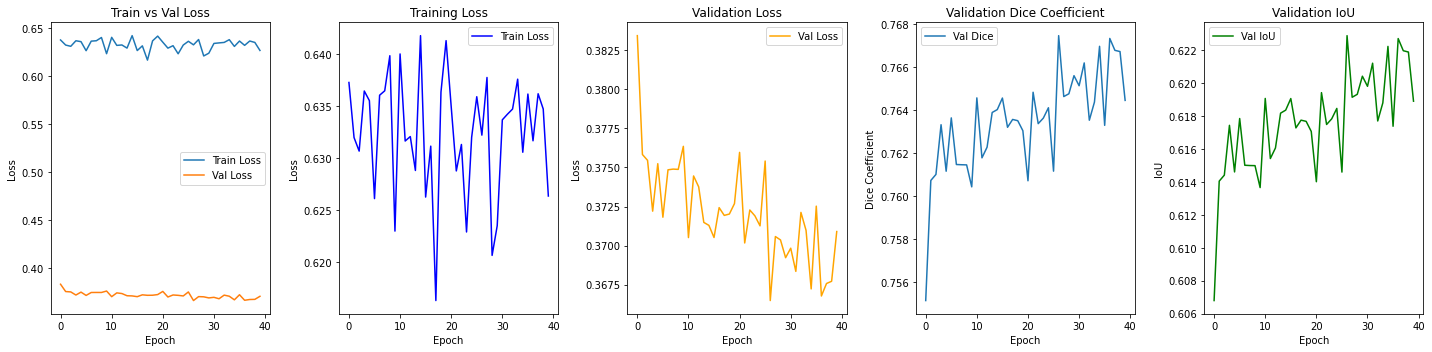

In [46]:
# Save metrics
dir_figures = './figures6bis_new_new'
os.makedirs(dir_figures, exist_ok=True)
save_metrics(train_losses, val_losses, val_dices, val_ious, dir_figures, name='metrics6bis_new_new_expeert_fine_tune2_from80_to_120epochs.png')

In [49]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from tqdm import tqdm
import os
import re
from model import UNet  # Your UNet model definition
from utils import get_device

# Find the latest fine-tuned model checkpoint
def find_latest_fine_tuned_model(checkpoint_dir):
    best_model = None
    best_epoch = -1

    for file_name in os.listdir(checkpoint_dir):
        match = re.match(r'best_model_fine_tune_epoch_(\d+)\.pth', file_name)
        if match:
            epoch = int(match.group(1))
            if epoch > best_epoch:
                best_epoch = epoch
                best_model = os.path.join(checkpoint_dir, file_name)

    if best_model:
        print(f"Using best fine-tuned model: {best_model}")
    else:
        raise FileNotFoundError("No fine-tuned model found.")

    return best_model

# Run inference to predict masks
def predict_masks_on_train(train_data, model_path, device):
    size = 224  # Assumed input size
    model = UNet(n_classes=1, n_channels=2, bilinear=False).to(device)  # Model with 2 input channels
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.eval()

    predicted_masks = []
    with torch.no_grad():
        for data in tqdm(train_data, desc="Predicting Masks on Train Data"):
            video = torch.from_numpy(data['video']).float()  # Shape: (frames, height, width)
            box = torch.from_numpy(data['box']).float()  # Box mask, same size as frames

            # Combine video frame and box as two channels
            video = video.unsqueeze(1)  # Add channel dimension: (frames, 1, H, W)
            box = box.unsqueeze(0).repeat(video.shape[0], 1, 1, 1)  # Repeat box for all frames
            inputs = torch.cat([video, box], dim=1)  # Shape: (frames, 2, H, W)

            # Split into batches for inference
            inputs_batches = torch.split(inputs, 64)  # Batching for efficiency
            preds = [model(batch.to(device)) for batch in inputs_batches]
            preds = torch.cat(preds, dim=0).cpu().squeeze(1)  # Remove extra channel dimension

            predicted_masks.append(preds)

    return predicted_masks

# Update the train data with predicted masks
def add_predicted_masks_to_data(train_data, predicted_masks, threshold=0.5):
    for data, mask_preds in zip(train_data, predicted_masks):
        mask_preds = (mask_preds > threshold).numpy()  # Binarize masks
        data['predicted_mask'] = mask_preds.mean(axis=0)  # Average mask across frames

# Plot the video frames with true masks, predicted masks, and true box
def plot_train_inference_results_with_masks(data, num_videos=10):
    fig, axes = plt.subplots(num_videos, 4, figsize=(20, 5 * num_videos))

    for i in range(num_videos):
        # Get a frame index where a mask exists
        mask_indices = data[i]['frames']  # Indices where masks exist
        idx = random.choice(mask_indices)  # Randomly pick one valid frame index

        # Extract relevant data
        video_frame = data[i]['video'][idx]
        true_box = data[i]['box']  # Ground-truth box
        true_mask = data[i]['label'][idx]  # Ground-truth mask
        predicted_mask = data[i]['predicted_mask']  # Predicted mask

        # Plot Original Frame
        axes[i, 0].imshow(video_frame, cmap='gray')
        axes[i, 0].set_title(f"Video Frame {idx}")
        axes[i, 0].axis('off')

        # Plot True Mask
        axes[i, 1].imshow(video_frame, cmap='gray')
        axes[i, 1].imshow(true_mask, cmap='viridis', alpha=0.5)
        axes[i, 1].set_title(f"True Mask {idx}")
        axes[i, 1].axis('off')

        # Plot Predicted Mask
        axes[i, 2].imshow(video_frame, cmap='gray')
        axes[i, 2].imshow(predicted_mask, cmap='viridis', alpha=0.5)
        axes[i, 2].set_title(f"Predicted Mask {idx}")
        axes[i, 2].axis('off')

        # Plot True Box
        axes[i, 3].imshow(video_frame, cmap='gray')
        axes[i, 3].imshow(true_box, cmap='jet', alpha=0.5)
        axes[i, 3].set_title(f"True Box {idx}")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
preprocessed_expert_data = np.load('./out/preprocessed6bis/preprocessed_expert_data.npy', allow_pickle=True)

checkpoint_dir = "./out/checkpoints6bis_new_new"  # Directory for fine-tuned model checkpoints
model_path = find_latest_fine_tuned_model(checkpoint_dir)
device = get_device()

# Predict masks
predicted_masks = predict_masks_on_train(preprocessed_expert_data, model_path, device)
add_predicted_masks_to_data(preprocessed_expert_data, predicted_masks, threshold=0.5)

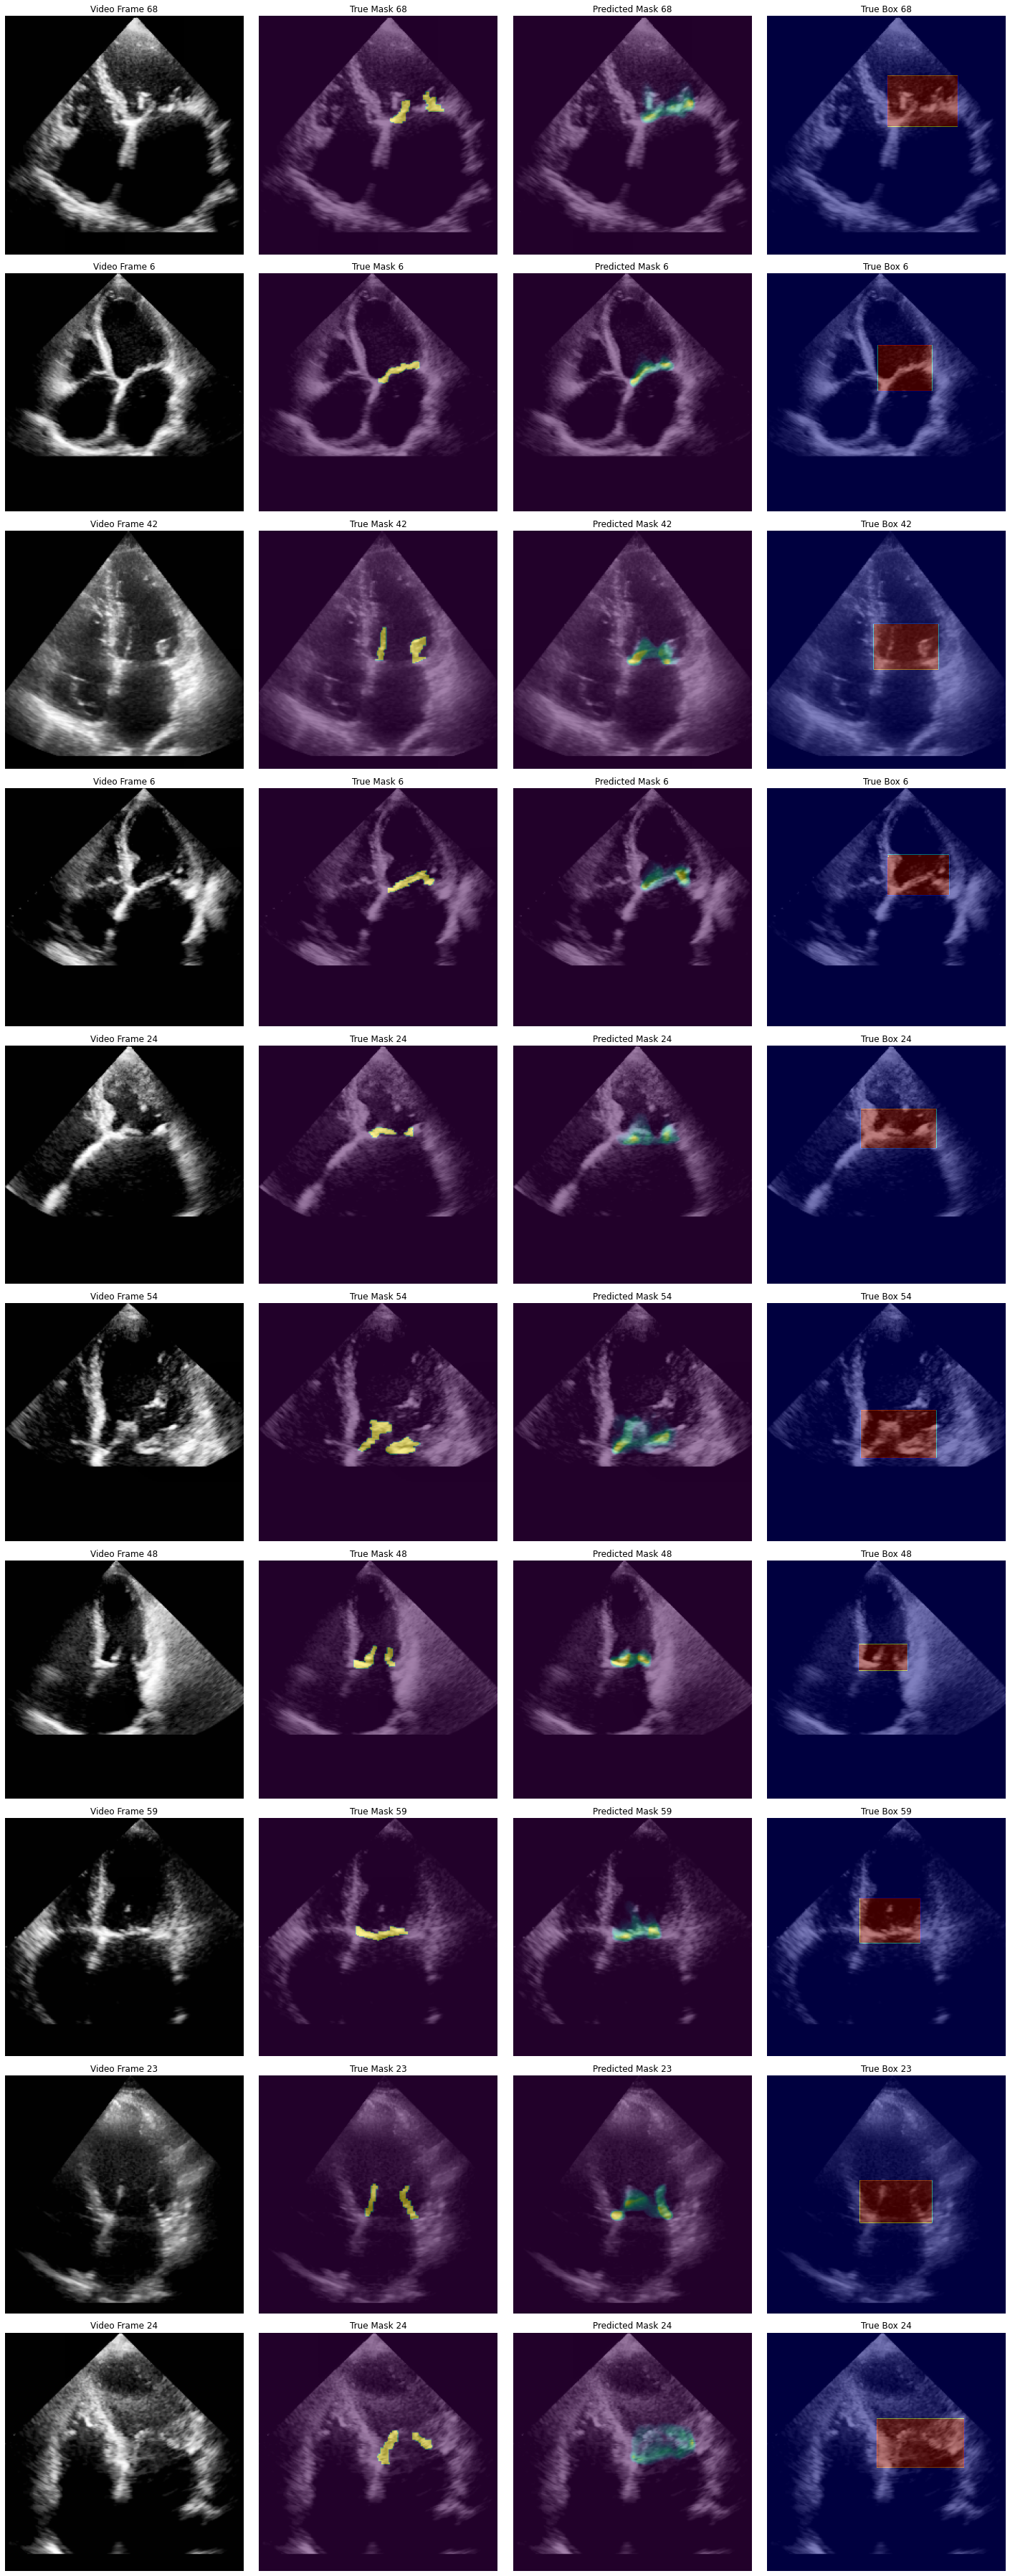

In [50]:
# Visualize the results
plot_train_inference_results_with_masks(preprocessed_expert_data, num_videos=10)